In [1]:
import timeit
import random
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

# Task A

## 1.1

In [2]:
# Read the data from the csv file
data = pd.read_csv("./datasets/PROJECT_CHAT.csv")
# data = pd.read_csv("./datasets/INTERWIKI_CONFLICT.csv")

In [3]:
usernames = data.groupby(["thread_subject", "page_name"])["username"].apply(list)
interactions = [username + username if len(username) == 1 else username for username in usernames]
# Create pair (edges) of interactions
duplicate_edges = [list(itertools.combinations(interaction, 2)) for interaction in interactions]
edges = [tuple(sorted(edge)) for duplicate_edge in duplicate_edges for edge in duplicate_edge]
counter = collections.Counter(edges)
weigted_edges = [(edge[0], edge[1], weight) for edge, weight in counter.items()]

In [4]:
G = nx.Graph()
G.add_weighted_edges_from(weigted_edges)

for node, degree in G.degree():
    G.nodes[node]["degree"] = degree

G.remove_edges_from(nx.selfloop_edges(G))

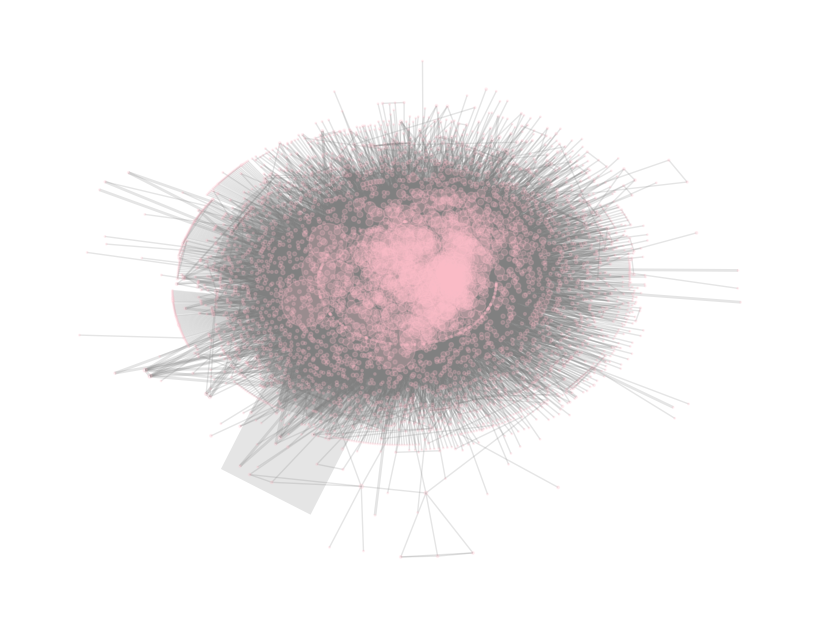

In [7]:
# Get the degree attribute of all the nodes
node_degree = [degree[1] for degree in G.nodes(data = "degree")]

# Get the weight attribute of all the edges
edge_weight = [weight[2] for weight in G.edges(data = "weight")]

plt.figure(figsize = (8,6))
nx.draw(G, pos = nx.kamada_kawai_layout(G), edge_color = "grey", width = edge_weight, node_size = node_degree, node_color = "pink", alpha = 0.2)
plt.show()

## 1.3

In [8]:
def sampling(interations, sample_size):
    samples = []
    length = 0
    while True:
        index = random.randint(0, len(interactions) - 1)
        samples.append(interactions[index])
        length += len(interactions[index])
        if length < sample_size:
            continue
        else:
            return samples

In [9]:
def cost(samples):
    duplicate_edges = [list(itertools.combinations(sample, 2)) for sample in samples]
    edges = [tuple(sorted(edge)) for duplicate_edge in duplicate_edges for edge in duplicate_edge]
    counter = collections.Counter(edges)
    weigted_edges = [(edge[0], edge[1], weight/10) for edge, weight in counter.items()]
    G = nx.Graph()
    G.add_weighted_edges_from(weigted_edges)

    for node, degree in G.degree():
        G.nodes[node]["degree"] = degree

    G.remove_edges_from(nx.selfloop_edges(G))

In [10]:
def complexity(interactions, step):
    times = []
    for i in range(0, nx.number_of_nodes(G), step):
        samples = sampling(interactions, i)
        average_time = timeit.timeit(lambda: cost(samples), number = 100) / 100
        times.append(average_time)

    x = range(0, nx.number_of_nodes(G) - 1, step)
    k = (times[10] - times[1]) / (x[10] - x[1])
    b = times[1] - k * x[1]
    fig, axs = plt.subplots(1, 2, figsize = (12, 4))
    axs[0].plot(x, [(i * (i - 1)) / 2 for i in x], color = "tab:red", label = r"$\dfrac{n \ ( \ n-1 \ )}{2}$")
    axs[0].plot(x, times, color = "tab:blue", label = "Actual time")
    axs[0].plot(x, [k * i + b for i in x], color = "tab:green", label = r"$kx + b$")
    axs[0].set_ylabel("Time (s)")
    axs[0].legend(loc="upper left")
    axs[0].set_title("Original graph")
    axs[1].plot(x, [(i * (i - 1)) / 2 for i in x], color = "tab:red", label = r"$\dfrac{n \ ( \ n-1 \ )}{2}$")
    axs[1].plot(x, times, color = "tab:blue", label = "Actual time")
    axs[1].plot(x, [k * i + b for i in x], color = "tab:green", label = r"$kx + b$")
    axs[1].legend(loc="upper right")
    axs[1].set_ylim(0, 0.05)
    axs[1].set_title("Zoomed graph")
    fig.supxlabel("Number of nodes")
    plt.show()

    return times

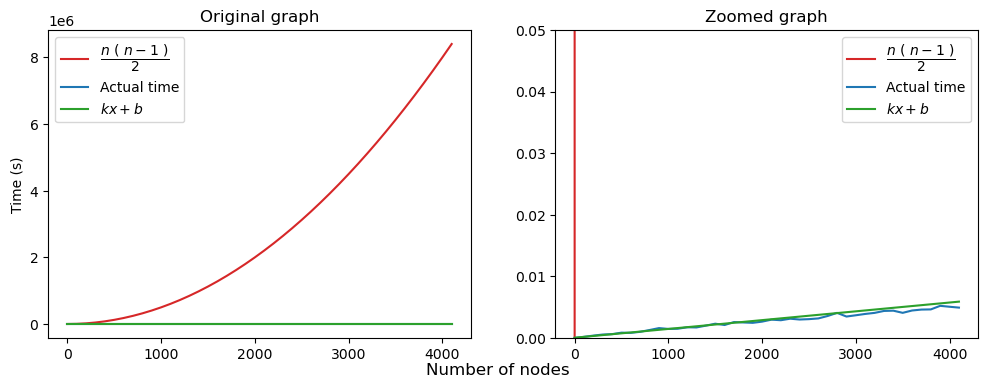

In [11]:
times = complexity(interactions, 100)

# Task B

## 2.1

In [12]:
def print_graph_statistics(graph):

    print("Number of nodes: ", graph.number_of_nodes())
    
    print("Number of edges: ", graph.number_of_edges())

    try:  # attempt to compute the diameter of the graph
        diam = nx.diameter(graph)
        print("Graph diameter: {}".format(diam))
    except:  # an error has  occurred
        print("\nERROR: Could not compute the diameter of the graph.")

    centrality = dict(sorted(nx.degree_centrality(graph).items(), key=lambda x: x[1], reverse = True))
    print("The highest degree centrality is: ", list(centrality.items())[0])
    
    print("Average degree: ", np.mean([deg for _, deg in graph.degree]))

    try:
        print("Average shortest path length: ", nx.average_shortest_path_length(graph))
    except:
        print("Average shortest path length: ", "ERROR")

    print("Average clustering coefficient: ", nx.average_clustering(graph))

    print("Number of connected components: {}".format(
        nx.number_connected_components(graph),
    ))

In [ ]:
print_graph_statistics(G)

Number of nodes:  4136
Number of edges:  40255

ERROR: Could not compute the diameter of the graph.
The highest degree centrality is:  ('Jura1', 0.28198307134220074)
Average degree:  19.46566731141199
Average shortest path length:  ERROR
Average clustering coefficient:  0.667082402728883
Number of connected components: 203


In [ ]:
degree_sequence = [d for n, d in G.degree()]
degreeCount = sorted(collections.Counter(degree_sequence).items())
for i in degreeCount: print(i)

In [ ]:
size_of_components = [len(component) for component in sorted(nx.connected_components(G), key = len, reverse = True)]
size_of_components[0]

3924

In [ ]:
# plot the largest connected component
largest_connected_component = max(nx.connected_components(G), key = len)
G_lcc = G.subgraph(largest_connected_component)
print_graph_statistics(G_lcc)

Number of nodes:  3924
Number of edges:  40242
Graph diameter: 6
The highest degree centrality is:  ('Jura1', 0.2972215141473362)
Average degree:  20.510703363914374
Average shortest path length:  2.740578381551284
Average clustering coefficient:  0.7022305855470592
Number of connected components: 1


# 2.2

In [12]:
# Compare the network with a random network
p = G.number_of_edges() / (G.number_of_nodes() * (G.number_of_nodes() - 1) / 2)
G_random = nx.erdos_renyi_graph(G.number_of_nodes(), p)

In [ ]:
print_graph_statistics(G_random)

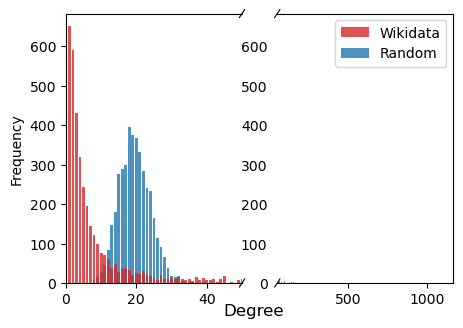

In [21]:
fig, axs = plt.subplots(1,2, sharey = True)
fig.set_size_inches(5, 3.5)
degree_sequence = [d for n, d in G_random.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
random = axs[0].bar(deg, cnt, width = 0.8, color = "tab:blue", alpha = 0.8)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0, 50)
axs[0].spines['right'].set_visible(False)

axs[1].bar(deg, cnt, width = 0.8, color = "tab:blue", alpha = 0.8)
axs[1].set_xlim(50, 1166)
axs[1].spines['left'].set_visible(False)
axs[1].tick_params(left = False)

degree_sequence = [d for n, d in G.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
wikidata = axs[0].bar(deg, cnt, width = 0.8, color = "tab:red", alpha = 0.8)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0, 50)
axs[0].spines['right'].set_visible(False)

axs[1].bar(deg, cnt, width = 0.8, color = "tab:red", alpha = 0.8)
axs[1].set_xlim(50, 1166)
axs[1].spines['left'].set_visible(False)
axs[1].tick_params(left = False)
fig.supxlabel("Degree")

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform = axs[0].transAxes, color = "k", clip_on = False, linewidth = 0.8)
axs[0].plot((1-d, 1+d), (-d, +d), **kwargs)
axs[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform = axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1-d, 1+d), **kwargs)
axs[1].plot((-d, +d), (-d, +d), **kwargs)


plt.legend([wikidata, random], ["Wikidata", "Random"])
plt.show()

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_88882/3245206193.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  plt.loglog(x, y, 'b.', markersize=8, color = "tab:red", alpha = 0.8)
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_88882/3245206193.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b." (-> color='b'). The keyword argument will take precedence.
  plt.loglog(x, y, 'b.', markersize=8, color = "tab:blue", alpha = 0.8)


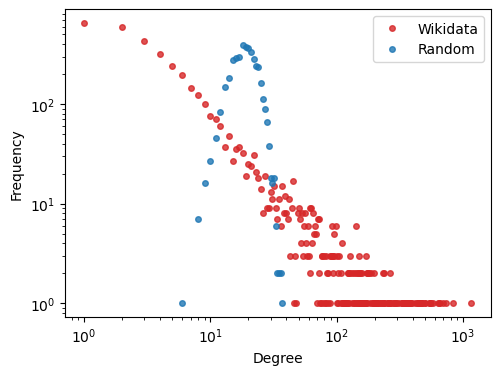

In [27]:
plt.figure(figsize=(5.5, 4))
degrees = dict(G.degree())
degree_hist = np.array([list(degrees.values()).count(i) for i in range(max(degrees.values()) + 1)])
x = np.arange(len(degree_hist))
y = degree_hist
plt.loglog(x, y, 'b.', markersize=8, color = "tab:red", alpha = 0.8)


degrees = dict(G_random.degree())
degree_hist = np.array([list(degrees.values()).count(i) for i in range(max(degrees.values()) + 1)])
x = np.arange(len(degree_hist))
y = degree_hist
plt.loglog(x, y, 'b.', markersize=8, color = "tab:blue", alpha = 0.8)

plt.legend(["Wikidata", "Random"])

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

## 2.4

In [6]:
new_data = pd.read_csv("./datasets/PROJECT_CHAT.csv")

In [15]:
new_usernames = new_data.groupby(["page_name"])["username"].apply(list)
new_interactions = [new_username + new_username if len(new_username) == 1 else new_username for new_username in new_usernames]
# Create pair (edges) of interactions
new_duplicate_edges = [list(itertools.combinations(new_interaction, 2)) for new_interaction in new_interactions]
new_edges = [tuple(sorted(edge)) for new_duplicate_edge in new_duplicate_edges for edge in new_duplicate_edge]
new_counter = collections.Counter(new_edges)
new_weigted_edges = [(edge[0], edge[1], weight/10) for edge, weight in new_counter.items()]

In [16]:
new_G = nx.Graph()
new_G.add_weighted_edges_from(new_weigted_edges)

for node, degree in new_G.degree():
    new_G.nodes[node]["degree"] = degree

new_G.remove_edges_from(nx.selfloop_edges(new_G))

In [ ]:
# Get the degree attribute of all the nodes
node_degree = [degree[1] for degree in new_G.nodes(data = "degree")]

# Get the weight attribute of all the edges
edge_weight = [weight[2] for weight in new_G.edges(data = "weight")]

plt.figure(figsize = (8,6))
nx.draw(new_G, pos = nx.kamada_kawai_layout(new_G), edge_color = "bisque", width = edge_weight, node_size = node_degree, node_color = "gold", alpha = 0.2)
plt.show()

In [ ]:
print_graph_statistics(new_G)

Number of nodes:  4136
Number of edges:  634138

ERROR: Could not compute the diameter of the graph.
The highest degree centrality is:  ('Ymblanter', 0.939540507859734)
Average degree:  306.6431334622824
Average shortest path length:  ERROR
Average clustering coefficient:  0.8467295419876029
Number of connected components: 2


In [ ]:
size_of_components = [len(component) for component in sorted(nx.connected_components(new_G), key = len, reverse = True)]
print(size_of_components[0:10])

# plot the largest connected component
largest_connected_component = max(nx.connected_components(new_G), key = len)
G_lcc = new_G.subgraph(largest_connected_component)
print_graph_statistics(G_lcc)

[4135, 1]
Number of nodes:  4135
Number of edges:  634138
Graph diameter: 3
The highest degree centrality is:  ('Ymblanter', 0.9397677793904209)
Average degree:  306.71729141475214
Average shortest path length:  1.9288937872679972
Average clustering coefficient:  0.8469343133399577
Number of connected components: 1


In [ ]:
degree_sequence = [d for n, d in new_G.degree()]
degreeCount = sorted(collections.Counter(degree_sequence).items())
for i in degreeCount: print(i)

(0, 1)
(5, 2)
(6, 2)
(11, 4)
(12, 5)
(18, 9)
(19, 10)
(27, 2)
(28, 2)
(37, 1)
(60, 7)
(92, 7)
(95, 11)
(99, 27)
(101, 30)
(102, 7)
(107, 32)
(108, 22)
(109, 19)
(110, 29)
(112, 11)
(113, 14)
(114, 34)
(115, 35)
(116, 71)
(117, 22)
(120, 56)
(121, 23)
(122, 30)
(123, 20)
(125, 20)
(126, 18)
(127, 45)
(128, 91)
(129, 35)
(130, 106)
(131, 59)
(132, 29)
(133, 18)
(134, 38)
(137, 53)
(138, 50)
(139, 79)
(141, 42)
(142, 89)
(143, 86)
(144, 69)
(145, 43)
(146, 17)
(147, 1)
(148, 23)
(150, 87)
(151, 55)
(153, 40)
(154, 45)
(155, 2)
(157, 19)
(158, 60)
(159, 31)
(160, 61)
(161, 33)
(162, 41)
(164, 129)
(165, 1)
(166, 2)
(167, 64)
(168, 34)
(169, 57)
(170, 42)
(171, 34)
(172, 33)
(174, 3)
(175, 1)
(176, 3)
(178, 3)
(179, 2)
(180, 1)
(182, 4)
(184, 6)
(185, 2)
(187, 5)
(188, 3)
(189, 2)
(190, 3)
(191, 3)
(192, 2)
(193, 2)
(195, 41)
(197, 5)
(198, 6)
(199, 13)
(200, 5)
(201, 2)
(202, 7)
(203, 2)
(204, 2)
(205, 5)
(206, 2)
(207, 5)
(208, 5)
(209, 3)
(210, 8)
(211, 1)
(212, 2)
(213, 43)
(214, 4)
(21

In [17]:
p = new_G.number_of_edges() / (new_G.number_of_nodes() * (new_G.number_of_nodes() - 1) / 2)
new_G_random = nx.erdos_renyi_graph(new_G.number_of_nodes(), p)

In [ ]:
print_graph_statistics(new_G_random)

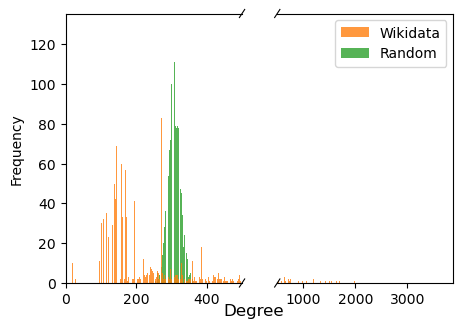

In [ ]:
fig, axs = plt.subplots(1,2, sharey = True)
fig.set_size_inches(5, 3.5)
degree_sequence = [d for n, d in new_G_random.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
random = axs[0].bar(deg, cnt, width = 0.8, color = "tab:green", alpha = 0.8)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0, 500)
axs[0].spines['right'].set_visible(False)

axs[1].bar(deg, cnt, width = 0.8, color = "tab:green", alpha = 0.8)
axs[1].set_xlim(500, 3885)
axs[1].spines['left'].set_visible(False)
axs[1].tick_params(left = False)

degree_sequence = [d for n, d in new_G.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
wikidata = axs[0].bar(deg, cnt, width = 0.8, color = "tab:orange", alpha = 0.8)
axs[0].set_ylabel("Frequency")
axs[0].set_xlim(0, 500)
axs[0].spines['right'].set_visible(False)

axs[1].bar(deg, cnt, width = 0.8, color = "tab:orange", alpha = 0.8)
axs[1].set_xlim(500, 3885)
axs[1].spines['left'].set_visible(False)
axs[1].tick_params(left = False)
fig.supxlabel("Degree")

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform = axs[0].transAxes, color = "k", clip_on = False, linewidth = 0.8)
axs[0].plot((1-d, 1+d), (-d, +d), **kwargs)
axs[0].plot((1-d, 1+d), (1-d, 1+d), **kwargs)

kwargs.update(transform = axs[1].transAxes)  # switch to the bottom axes
axs[1].plot((-d, +d), (1-d, 1+d), **kwargs)
axs[1].plot((-d, +d), (-d, +d), **kwargs)
plt.legend([wikidata, random], ["Wikidata", "Random"])
plt.show()

# Task C

## 3.1

In [13]:
def select_two_editors(G):
    while True:
        n1 = np.random.choice(G.nodes())
        n2 = np.random.choice(G.nodes())
        if n1 != n2:
            break
    two_editors = [n1,n2]
    return two_editors

In [14]:
def gen_model(G, infected_node, interaction, threshold):
    from ndlib.models import epidemics
    import ndlib.models.ModelConfig as config

    model = epidemics.ThresholdModel(G)
    config = config.Configuration()
    config.add_model_initial_configuration("Infected", infected_node)
    for node in G.nodes():
        config.add_node_configuration("threshold", node, threshold)
    model.set_initial_status(config)
    
    iterations = model.iteration_bunch(interaction)
    trends = model.build_trends(iterations)
    return model, trends

In [15]:
def get_infected_nodes(model):
    infected_nodes = [node for node, status in model.status.items() 
                      if status == 1 and model.initial_status[node] == 0]

    return infected_nodes

In [16]:
def visualize_the_infected_nodes(G, selected_editors, infected_nodes, neighboring_similar_editors, with_labels = True):

    node_colors = []
    infected_neighboring_similar_editors = [node for node in infected_nodes if node in neighboring_similar_editors]
    infected_neighboring_editors = [node for node in infected_nodes if node in G.nodes and node not in neighboring_similar_editors]
    
    print("The selected editors are: ", selected_editors)
    print("The infected neighboring editors is: ", infected_nodes)
    print("The infected neighboring similar editors is: ", infected_neighboring_similar_editors)
    
    for node in G.nodes:
            

        if node in infected_neighboring_editors:
            node_colors.append('tab:grey')
        
        elif node in infected_neighboring_similar_editors:
            node_colors.append('tab:orange')

        elif node in selected_editors:
            node_colors.append('tab:red')
            
        else:
            node_colors.append('tab:blue')

    nx.draw(G, pos=nx.kamada_kawai_layout(G) , node_color = node_colors, with_labels = with_labels)
    plt.show()

In [ ]:
# ['77.180.35.91', '77.179.250.59']

In [25]:
# selected_editors = select_two_editors(G)
selected_editors = ['77.180.35.91', '77.179.250.59']
selected_editors_centralities = {selected_editors[0]:nx.degree_centrality(G)[selected_editors[0]], 
                                 selected_editors[1]:nx.degree_centrality(G)[selected_editors[1]]}
selected_editors_centralities

{'77.180.35.91': 0.0038694074969770256, '77.179.250.59': 0.0012091898428053206}

In [26]:
similar_editors = {node: centrality for node, centrality in nx.degree_centrality(G).items() if centrality in selected_editors_centralities.values()}

In [27]:
neighbors = [neighbor for editor in selected_editors for neighbor in list(G.neighbors(editor))]
neighboring_similar_editors = [node for node in neighbors if node in similar_editors.keys()]
G_neighboring_editors = G.subgraph(neighbors + selected_editors)
neighbors

['78.48.189.69',
 'Sic19',
 'ArthurPSmith',
 'Mahir256',
 'Magnus Manske',
 '77.179.186.215',
 '85.179.115.121',
 'Tagishsimon',
 'Matěj Suchánek',
 'Sjoerddebruin',
 '92.228.155.106',
 'Pasleim',
 '77.179.253.70',
 '77.180.82.131',
 '78.55.177.69',
 '85.182.28.185',
 '77.180.123.82',
 'Matěj Suchánek',
 'Jarekt',
 'billinghurst',
 '85.181.108.182']

The selected editors are:  ['77.180.35.91', '77.179.250.59']
The infected neighboring editors is:  ['78.48.189.69', '77.179.186.215', '85.179.115.121', 'Isranoahsamue', '80.171.248.200', '85.182.28.185', '78.55.254.253', '77.179.86.244', '77.180.123.82', '85.181.108.182', '92.228.155.106', '78.55.177.69', '77.179.253.70', '77.180.82.131', '92.229.132.140']
The infected neighboring similar editors is:  ['77.180.123.82', '85.181.108.182', '77.179.253.70', '77.180.82.131']


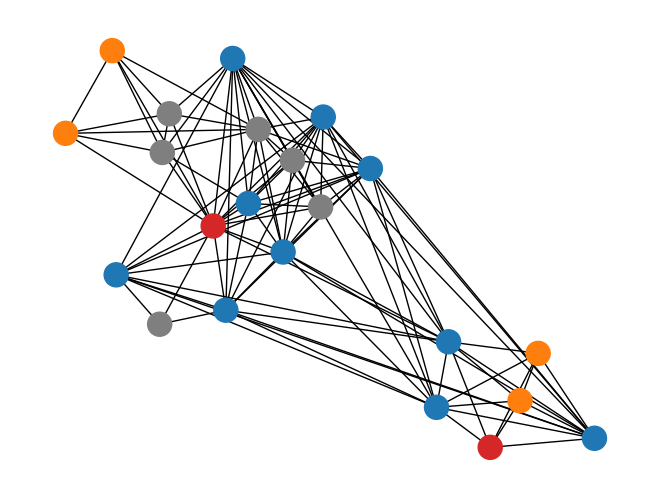

In [28]:
threshold_average, threshold_average_trend = gen_model(G, selected_editors, 10, threshold = 0.2)
infected_nodes_average = get_infected_nodes(threshold_average)
visualize_the_infected_nodes(G_neighboring_editors, selected_editors, 
                             infected_nodes_average, 
                             neighboring_similar_editors, 
                             with_labels = False)

The selected editors are:  ['77.180.35.91', '77.179.250.59']
The infected neighboring editors is:  []
The infected neighboring similar editors is:  []


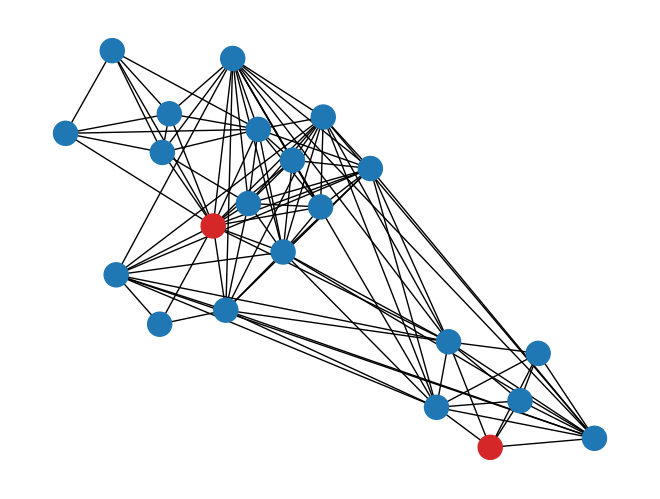

In [29]:
threshold_best, threshold_best_trends = gen_model(G, selected_editors, 10, threshold = 0.4)
infected_nodes_best = get_infected_nodes(threshold_best)
visualize_the_infected_nodes(G_neighboring_editors, selected_editors, 
                             infected_nodes_best, 
                             neighboring_similar_editors, 
                             with_labels = False)

The selected editors are:  ['77.180.35.91', '77.179.250.59']
The infected neighboring editors is:  ['FRacco', 'Stryn', 'Jc86035', 'Amire80', 'Jeblad', 'PKM', 'Sdkb', 'Animalparty', 'Jura1', 'ChristianKl', 'Mahir256', 'The Anome', 'Innocent bystander', 'TomT0m', 'WhisperToMe', 'Jheald', 'Ghouston', 'Jmabel', 'Pigsonthewing', 'Gamaliel', 'Ayack', 'SCIdude', 'GerardM', 'Toni 001', 'GZWDer', 'Izno', 'Jérémy-Günther-Heinz Jähnick', 'Denny', 'Ivanhercaz', 'Bouzinac', 'Matěj Suchánek', 'Ajraddatz', 'PinkAmpersand', 'Iste Praetor', 'Arkanosis', 'Jasper Deng', 'Sk!d', 'Hazard-SJ', 'Dipsacus fullonum', 'Máté', 'Xinbenlv', 'TweetsFactsAndQueries', 'Vojtěch Dostál', 'Tbhotch', 'FelixReimann', 'The Anonymouse', 'Napoleon.tan', 'Lydia Pintscher (WMDE)', 'Denny Vrandečić (WMDE)', 'Moe Epsilon', 'Ymblanter', 'Pyfisch', 'FreightXPress', 'StevenJ81', 'Pasleim', 'AmaryllisGardener', 'Circeus', 'Swpb', 'Was a bee', 'Donald Trung', 'GPSLeo', 'VIGNERON', 'Strakhov', '117.13.95.87', 'Koavf', 'Liuxinyu970226'

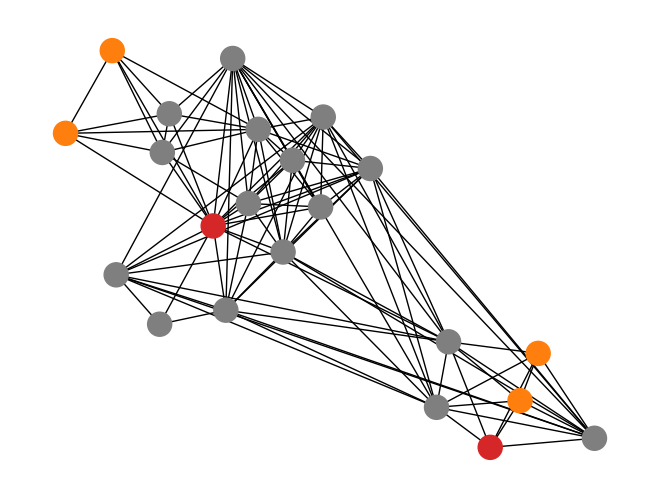

In [31]:
threshold_worst, threshold_worst_trends = gen_model(G, selected_editors, 10, threshold = 0.04)
infected_nodes_worst = get_infected_nodes(threshold_worst)
visualize_the_infected_nodes(G_neighboring_editors, selected_editors, 
                             infected_nodes_worst, 
                             neighboring_similar_editors, 
                             with_labels = False)

In [32]:
paths = list(itertools.combinations(neighboring_similar_editors, 2))
for path in paths:
    shortest_path = nx.shortest_path(G, path[0], path[1], method = 'dijkstra')
    for node in selected_editors:
        if node in shortest_path:
            print(node, "in", shortest_path)

77.180.35.91 in ['77.179.253.70', '77.180.35.91', 'Matěj Suchánek', '77.180.123.82']
77.180.35.91 in ['77.179.253.70', '77.180.35.91', 'Matěj Suchánek', '85.181.108.182']
77.180.35.91 in ['77.180.82.131', '77.180.35.91', 'Matěj Suchánek', '77.180.123.82']
77.180.35.91 in ['77.180.82.131', '77.180.35.91', 'Matěj Suchánek', '85.181.108.182']


## Priority list

In [33]:
edges = list(G.edges())
edges = [tuple(sorted(edge)) for edge in edges]
pages = data["page_name"].unique()
len(pages)

131

In [34]:
page_counters = {}
page_data = pd.DataFrame(usernames.apply(list)).groupby("page_name")["username"].apply(list).reset_index()
for page in pages:
    threads = list(page_data[page_data["page_name"] == page]["username"].apply(list))[0]
    duplicate_edges = [list(itertools.combinations(thread, 2)) for thread in threads]
    page_edges = [tuple(sorted(edge)) for duplicate_edge in duplicate_edges for edge in duplicate_edge]
    page_edges = [page_edge for page_edge in page_edges if page_edge in edges]
    page_counter = collections.Counter(page_edges)
    page_counters[page] = page_counter

# page_counters

In [35]:
edge_dict = {}
for edge in edges:
    edge_dict[edge] = []

for page in pages:
    page_counter = page_counters[page]
    for edge in edges:
        if edge in page_counter:
            edge_dict[edge].append(page_counter[edge])
        else:
            edge_dict[edge].append(0)
edge_dict

{('FRacco', 'Stryn'): [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 ('FRacco', 'Glaisher'): [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [36]:
# Count the number of interactions per edge
interactions = [interaction for interactions in list(edge_dict.values()) for interaction in interactions if interaction >= 1]
# Find the 99th percentile
ninety_nine_percentile = np.percentile(interactions, 99, method="nearest")
threshold = ninety_nine_percentile
threshold

5

In [37]:
potential_trolling_pages = {}
for edge, value in edge_dict.items():
    for interaction in value:
        if interaction > threshold:
            potential_trolling_pages[edge] = value
        else:
            continue

In [38]:
# use dictionary to create dataframe
trolling_editors = pd.DataFrame.from_dict(potential_trolling_pages, orient = "index")
trolling_editors = trolling_editors.T
infected_nodes = list(set([node for edge in trolling_editors.columns for node in edge]))
len(infected_nodes)

125

In [39]:
possible_priority_list = trolling_editors.iloc[:,0:-1].apply(lambda x: (x > threshold).sum())
Q1 = possible_priority_list.quantile(0.25)
Q3 = possible_priority_list.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

priority_list_threshold = upper_bound
priority_list_threshold

3.5

In [40]:
priority_list = {}
for i in range(len(trolling_editors)):    
    for index, value in possible_priority_list.items():
        if value > priority_list_threshold:
            priority_list[index] = value

priority_list

{('Jeblad', 'Stryn'): 4,
 ('Ajraddatz', 'Jeblad'): 4,
 ('ChristianKl', 'Jura1'): 14,
 ('Jura1', 'Pigsonthewing'): 9,
 ('Jmabel', 'Jura1'): 6,
 ('GerardM', 'Jura1'): 5,
 ('Jheald', 'Jura1'): 4,
 ('Innocent bystander', 'Jura1'): 6,
 ('Ghouston', 'Jura1'): 10,
 ('Jura1', 'Tagishsimon'): 10,
 ('ChristianKl', 'Pigsonthewing'): 9,
 ('ArthurPSmith', 'ChristianKl'): 6,
 ('ChristianKl', 'MisterSynergy'): 5,
 ('ChristianKl', 'billinghurst'): 5,
 ('ChristianKl', 'GerardM'): 5,
 ('Filceolaire', 'TomT0m'): 15,
 ('Ghouston', 'Jmabel'): 5,
 ('Pigsonthewing', 'Succu'): 4,
 ('Filceolaire', 'Snipre'): 6,
 ('Filceolaire', 'Micru'): 4,
 ('Filceolaire', 'Lavallen'): 5}